In [1]:
import pandas as pd
import pickle, os, re


def collect(df_dict):
    mode_dict = {'0':'interday', '1':'intraday'}
    act_dict = {'r':'relu', 't':'tanh', 's':'sigmoid'}

    hy_params = os.listdir('logs/')
    for hy_param in hy_params:
        hypers = hy_param.split('_')
        if len(hypers) < 4:
            continue

        act_opti_hy_params = os.listdir('logs/'+hy_param+'/')
        for act_opti_hy_param in act_opti_hy_params:
            if len(act_opti_hy_param.split('.')) > 1:
                continue

            items = os.listdir('logs/' + hy_param + '/' + act_opti_hy_param + '/')
            activation, optimizer = act_opti_hy_param.split('_')[0], act_opti_hy_param.split('_')[1]
            for item in items:
                if item.endswith('.pkl'):
                    model_name = item.split('_')[0]
                    with open('logs/' + hy_param + '/' + act_opti_hy_param + '/' + item, 'rb') as file:
                        history, test_loss, test_metrics = pickle.load(file)
                    history_df = pd.DataFrame(history)
                    insert = [int(hypers[0]), mode_dict[hypers[1]], hypers[2],hypers[3], activation, optimizer,
                              history_df['IC'].values[-1], history_df['val_IC'].values[-1], test_metrics]
                    df_dict[model_name].loc[len(df_dict[model_name])] = insert
    return df_dict

In [2]:
df_dict = {}
models = ['x', 'y', 'cnn', 'lstm', 'bilstm', 'tcn']
for model in models:
    df_dict[model] = pd.DataFrame(columns=['size','mode','bar','market','activation','optimizer',
                                           'train','valid','test'])
result = collect(df_dict)
for model, df in df_dict.items():
    df = df.sort_values(by=['mode', 'market', 'size', 'activation','optimizer'], ascending=True)
    df.index = range(len(df))
    df_dict[model] = df
    
write = pd.ExcelWriter('logs/output.xls')
for model, df in df_dict.items():
    df.to_excel(excel_writer=write,sheet_name=model, header=True, encoding="utf-8", index=False)
write.save()
write.close()

/Users/geek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/geek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/geek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/geek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


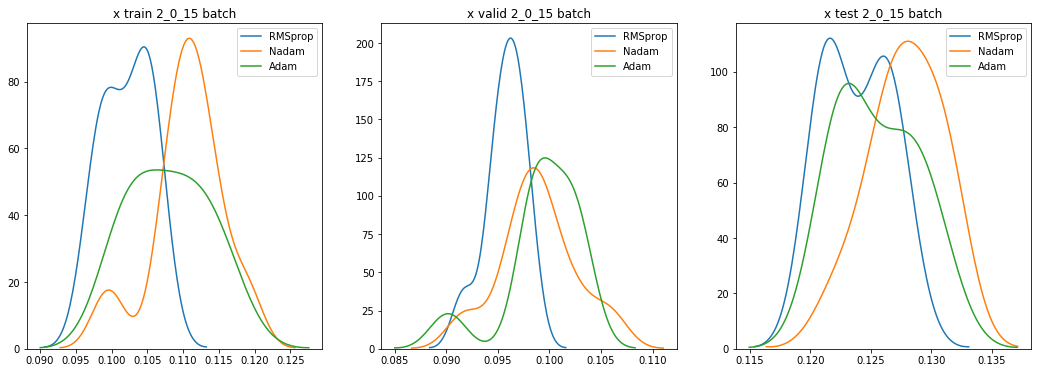

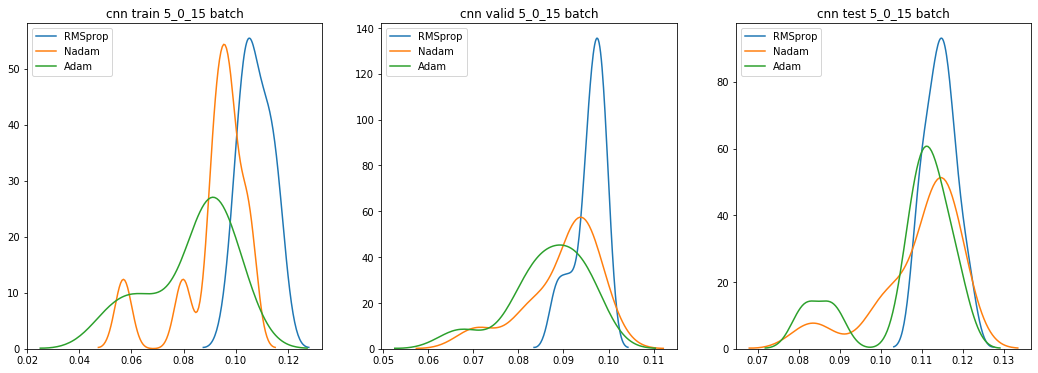

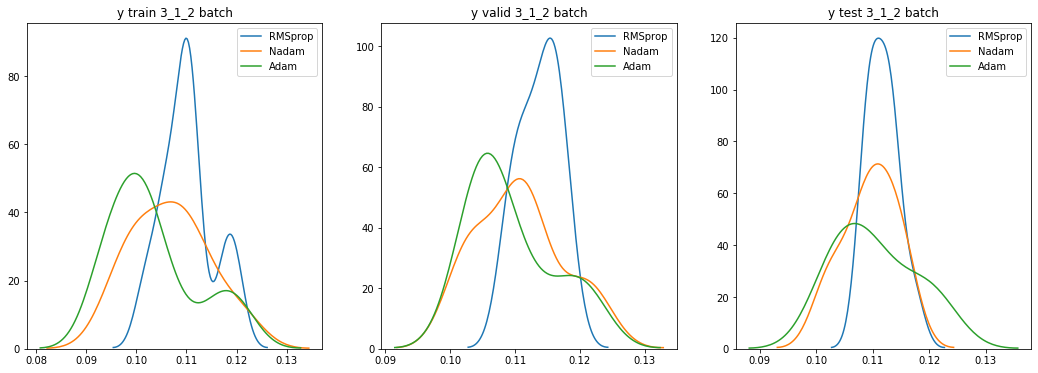

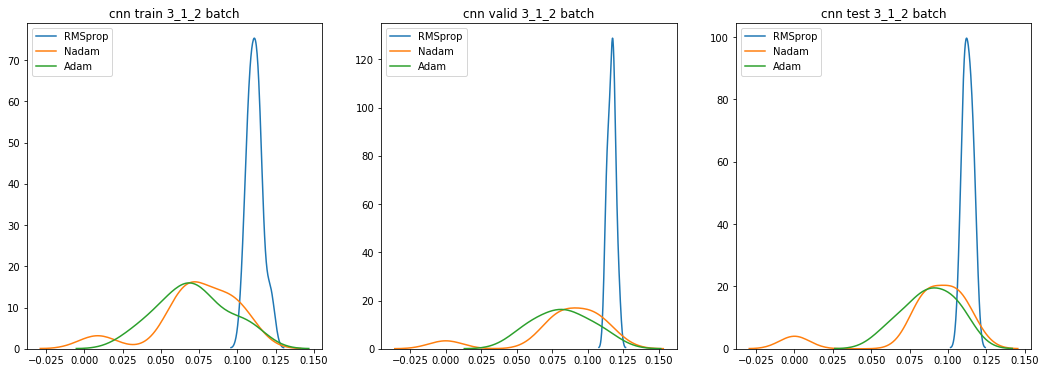

In [72]:
import pandas as pd
import pickle, os, re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict


def collect():
    df_dict = defaultdict(dict)
    mode_dict = {'0':'interday', '1':'intraday'}
    act_dict = {'r':'relu', 't':'tanh', 's':'sigmoid'}

    hy_params = os.listdir('logs/')
    for hy_param in hy_params:
        hypers = hy_param.split('_')
        if len(hypers) < 4:
            continue
        
        optimizers = os.listdir('logs/'+hy_param+'/')
        for optimizer in optimizers:
            if optimizer.startswith('.'):
                continue
            
            pkl_files = os.listdir('logs/' + hy_param + '/' + optimizer + '/')
            for pkl_file in pkl_files:
                if pkl_file.startswith('.'):
                    continue
                
                model_name = pkl_file.split('_')[0]
                with open('logs/' + hy_param + '/' + optimizer + '/' + pkl_file, 'rb') as file:
                    batch_IC_res, signal_IC_res = pickle.load(file)
                df_dict[model_name+'_'+hy_param][optimizer] = [batch_IC_res, signal_IC_res]
    return df_dict



df_dict = collect()
p_s = 0
mode = ['batch', 'signal']
for hyper, value in df_dict.items():
    
    model_name, setting = hyper.split('_')[0], '_'.join(hyper.split('_')[1:-1])
    fig = plt.figure(figsize=(18,6))
    axs = []
    for i in range(3):
        axs.append(fig.add_subplot(131+i))
    
    for opti, perform in value.items():
        sns.distplot(perform[p_s][:,0], ax=axs[0], label=opti, hist=False)
        axs[0].set_title('%s %s %s %s' % (model_name, 'train', setting, mode[p_s]))
        
        sns.distplot(perform[p_s][:,1], ax=axs[1], label=opti, hist=False)
        axs[1].set_title('%s %s %s %s' % (model_name, 'valid', setting, mode[p_s]))
        
        sns.distplot(perform[p_s][:,2], ax=axs[2], label=opti, hist=False)
        axs[2].set_title('%s %s %s %s' % (model_name, 'test', setting, mode[p_s]))
    for ax in axs:
        ax.legend()
    
    fig.show()